In [1]:
from Funcs.Utility import *
import numpy as np
import pandas as pd
from typing import Dict, Callable, Union, Tuple, List, Optional, Iterable, Any
from datetime import timedelta as td
from scipy import stats
import ray
import warnings
import time

In [2]:
from scipy import stats as sp
from scipy.signal import correlate
from sklearn.preprocessing import StandardScaler
from functools import reduce
import matplotlib.pyplot as plt
import seaborn as sns
import logging
from typing import Dict, List


# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger()

In [3]:
data = pd.read_pickle(os.path.join(PATH_INTERMEDIATE, 'proc_updated.pkl'))

In [4]:
# Check the type of the loaded data
print(f"Type of data: {type(data)}")

Type of data: <class 'dict'>


In [5]:
# List all keys in the dictionary
print("Keys in the data dictionary:")
print(data.keys())

Keys in the data dictionary:
dict_keys(['LOC_LABEL', 'LOC_DST', 'LOC_CLS', 'ACE_UNK', 'ACE_FOT', 'ACE_WLK', 'ACE_VHC', 'ACE_BCC', 'ACE_RUN', 'ACE_TLT', 'ACT', 'WLS', 'FCL_VAL', 'FAC_VAL', 'FDI_VAL', 'FST_VAL', 'APP_DUR_SOCIAL', 'APP_DUR_SYSTEM', 'APP_DUR_ENTER', 'APP_DUR_INFO', 'APP_DUR_WORK', 'APP_DUR_HEALTH', 'APP_DUR_UNKNOWN', 'APP_CAT', 'BAT_LEV', 'BAT_STA', 'BAT_TMP', 'BAT_PLG', 'CALL_DUR', 'CALL_CNT', 'DATA_RCV', 'DATA_SNT', 'DATA_MRCV', 'DATA_MSNT', 'INST_JAC', 'MSG_SNT', 'MSG_RCV', 'MSG_ALL', 'WIFI_COS', 'WIFI_EUC', 'WIFI_MAN', 'WIFI_JAC', 'SCR_EVENT', 'SCR_DUR', 'RING', 'CHG', 'PWR', 'ONOFF', 'BT_BondState', 'BT_DeviceType', 'BT_classType', 'Dozemode', 'FitbitHeartrate', 'FitbitStepcount', 'Fitbitcalorie', 'Fitbitdistance', 'keyevent_CAT', 'keyevent_DIST', 'keyevent_TIME', 'Notification_VIS', 'Notification_CAT'])


In [6]:
data

{'LOC_LABEL': pcode  timestamp                       
 P126   2021-12-06 15:30:30.622000+09:00      none
        2021-12-06 15:32:16.025000+09:00      none
        2021-12-06 15:34:15.170000+09:00      none
        2021-12-06 15:39:25.419000+09:00      none
        2021-12-06 15:41:02.878000+09:00    social
                                             ...  
 P083   2021-12-28 23:33:06.771000+09:00      home
        2021-12-28 23:39:04.200000+09:00      home
        2021-12-28 23:45:01.310000+09:00      home
        2021-12-28 23:45:36.581000+09:00      home
        2021-12-28 23:51:40.129000+09:00      home
 Name: label, Length: 612941, dtype: object,
 'LOC_DST': pcode  timestamp                       
 P126   2021-12-06 15:30:30.622000+09:00      0.000000
        2021-12-06 15:32:16.025000+09:00     75.783302
        2021-12-06 15:34:15.170000+09:00     78.214386
        2021-12-06 15:39:25.419000+09:00     16.788128
        2021-12-06 15:41:02.878000+09:00     13.604548
             

In [7]:
# Define the list of relevant keys for Mobility
relevant_keys_mobility = ['LOC_LABEL']

In [8]:
import logging
from tqdm import tqdm

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger()

# Function to remove duplicates by keeping the first occurrence
def remove_duplicates(series, key):
    initial_count = len(series)
    series_unique = series[~series.index.duplicated(keep='first')]
    duplicates_removed = initial_count - len(series_unique)
    if duplicates_removed > 0:
        logger.info(f"Removed {duplicates_removed} duplicate entries in {key}.")
    else:
        logger.info(f"No duplicates found in {key}.")
    return series_unique

# Process 'LOC_LABEL' data
def process_mobility_data(data: Dict[str, any]) -> pd.DataFrame:
    """
    Processes the 'LOC_LABEL' data and returns a cleaned DataFrame.

    Parameters:
    - data (Dict[str, any]): The raw data dictionary.

    Returns:
    - pd.DataFrame: Cleaned LOC_LABEL DataFrame.
    """
    key = 'LOC_LABEL'
    if key not in data:
        logger.error(f"Key '{key}' not found in data.")
        return pd.DataFrame()

    value = data[key]
    logger.info(f"Processing key: {key}, Type: {type(value)}")

    if not isinstance(value, pd.Series):
        logger.error(f"Expected pd.Series for '{key}', got {type(value)}. Skipping.")
        return pd.DataFrame()

    # Remove duplicates by keeping the first occurrence
    value_unique = remove_duplicates(value, key)

    # Convert Series to DataFrame
    df = value_unique.to_frame(name=key)

    # Handle missing values
    df[key].fillna('unknown', inplace=True)

    # Ensure MultiIndex ['pcode', 'timestamp']
    if not isinstance(df.index, pd.MultiIndex):
        df.reset_index(inplace=True)
        df.set_index(['pcode', 'timestamp'], inplace=True)
        logger.info("Set MultiIndex to ['pcode', 'timestamp'].")
    else:
        logger.info("DataFrame already has a MultiIndex.")

    # Convert 'timestamp' to datetime if not already
    if not pd.api.types.is_datetime64_any_dtype(df.index.get_level_values('timestamp')):
        df.index = df.index.set_levels(
            [
                df.index.get_level_values('pcode'),
                pd.to_datetime(df.index.get_level_values('timestamp'))
            ]
        )
        logger.info("Converted 'timestamp' to datetime.")

    # Remove duplicate indices
    df = df[~df.index.duplicated(keep='first')]
    logger.info("Removed duplicate index entries.")

    return df

# Process the mobility data
mobility_df = process_mobility_data(data)

# Display the first few rows
if not mobility_df.empty:
    print("\nProcessed Mobility DataFrame Head:")
    print(mobility_df.head())
else:
    logger.error("Mobility DataFrame is empty after processing.")


2024-11-13 04:54:55,086 - INFO - Processing key: LOC_LABEL, Type: <class 'pandas.core.series.Series'>
2024-11-13 04:54:55,097 - INFO - Removed 36 duplicate entries in LOC_LABEL.
2024-11-13 04:54:55,106 - INFO - DataFrame already has a MultiIndex.
2024-11-13 04:54:55,139 - INFO - Removed duplicate index entries.



Processed Mobility DataFrame Head:
                                       LOC_LABEL
pcode timestamp                                 
P126  2021-12-06 15:30:30.622000+09:00      none
      2021-12-06 15:32:16.025000+09:00      none
      2021-12-06 15:34:15.170000+09:00      none
      2021-12-06 15:39:25.419000+09:00      none
      2021-12-06 15:41:02.878000+09:00    social


In [9]:
mobility_df

LOC_LABEL
pcode timestamp                                 
P126  2021-12-06 15:30:30.622000+09:00      none
      2021-12-06 15:32:16.025000+09:00      none
      2021-12-06 15:34:15.170000+09:00      none
      2021-12-06 15:39:25.419000+09:00      none
      2021-12-06 15:41:02.878000+09:00    social
...                                          ...
P083  2021-12-28 23:33:06.771000+09:00      home
      2021-12-28 23:39:04.200000+09:00      home
      2021-12-28 23:45:01.310000+09:00      home
      2021-12-28 23:45:36.581000+09:00      home
      2021-12-28 23:51:40.129000+09:00      home

[612905 rows x 1 columns]

In [10]:
def extract_mobility_features(window_data: pd.Series) -> Dict[str, float]:
    """
    Extracts mobility-related features from a window of LOC_LABEL data.

    Parameters:
    - window_data (pd.Series): Series of location labels within the window.

    Returns:
    - Dict[str, float]: Dictionary of extracted mobility features.
    """
    features = {}
    try:
        if window_data.empty:
            logger.debug("Window data is empty.")
            return features

        # Number of location changes
        loc_changes = window_data.ne(window_data.shift()).sum() - 1  # subtract 1 for the first entry
        loc_changes = max(loc_changes, 0)  # Ensure non-negative
        features['LOC_CHANGE_CNT'] = loc_changes

        # Entropy of location labels
        counts = window_data.value_counts()
        entropy = sp.entropy(counts, base=2)
        features['LOC_ENTROPY'] = entropy

        # Time spent in each location
        # Calculate time differences
        window_data = window_data.sort_index()  # Ensure sorted by timestamp
        timestamps = window_data.index.get_level_values('timestamp')
        time_deltas = timestamps.to_series().diff().dt.total_seconds().fillna(0)

        # Assign time deltas to current location
        loc_time = window_data.groupby(window_data).apply(
            lambda x: time_deltas[x.index].sum()
        )

        # Populate time spent in each location
        for loc, dur in loc_time.items():
            features[f'LOC_TIME_{loc.upper()}'] = dur / 60  # Convert seconds to minutes

        # Most frequent location
#         if not counts.empty:
#             mode_loc = counts.idxmax()
#             features['LOC_MODE'] = mode_loc
#         else:
#             features['LOC_MODE'] = 'unknown'

        # Average duration between location changes
        if loc_changes > 0:
            avg_dur = time_deltas.sum() / loc_changes
            features['LOC_AVG_DUR'] = avg_dur / 60  # minutes
            features['LOC_STD_DUR'] = time_deltas.std() / 60  # minutes
        else:
            features['LOC_AVG_DUR'] = 0
            features['LOC_STD_DUR'] = 0

    except Exception as e:
        logger.error(f"Error extracting mobility features: {e}")

    return features

In [11]:
def sliding_window_feature_extraction_mobility(
    mobility_df: pd.DataFrame,
    window_size_minutes: int,
    step_size_minutes: int = None
) -> pd.DataFrame:
    """
    Extracts mobility features using a sliding window approach.

    Parameters:
    - mobility_df (pd.DataFrame): DataFrame with 'LOC_LABEL' and MultiIndex ['pcode', 'timestamp'].
    - window_size_minutes (int): Size of the sliding window in minutes.
    - step_size_minutes (int, optional): Step size in minutes. Defaults to window_size_minutes.

    Returns:
    - pd.DataFrame: Extracted mobility features.
    """
    if step_size_minutes is None:
        step_size_minutes = window_size_minutes  # Default to non-overlapping windows

    extracted_features = []

    # Ensure the DataFrame is sorted by pcode and timestamp
    mobility_df = mobility_df.sort_index(level=['pcode', 'timestamp'])

    for pcode, group in mobility_df.groupby(level='pcode'):
        # Reset 'pcode' level and keep 'timestamp' as a column
        group = group.reset_index(level='pcode', drop=True).reset_index()

        # Set 'timestamp' as datetime index
        group = group.set_index('timestamp')

        # Define the sliding window
        start_time = group.index.min()
        end_time = group.index.max()

        current_start = start_time
        current_end = current_start + pd.Timedelta(minutes=window_size_minutes)

        while current_end <= end_time:
            window = group[current_start:current_end]
            feature_row = {}
            feature_row['pcode'] = pcode
            feature_row['window_end_time'] = current_end

            data = window['LOC_LABEL']

            mobility_feats = extract_mobility_features(data)
            if not mobility_feats:
                pass  # No features extracted
            else:
                feature_row.update(mobility_feats)

            # Only add the feature row if it contains at least one feature
            if feature_row:
                extracted_features.append(feature_row)

            # Move the window
            current_start += pd.Timedelta(minutes=step_size_minutes)
            current_end = current_start + pd.Timedelta(minutes=window_size_minutes)

    mobility_feature_df = pd.DataFrame(extracted_features)
    if not mobility_feature_df.empty:
        mobility_feature_df = mobility_feature_df.set_index(['pcode', 'window_end_time'])

    return mobility_feature_df

In [12]:
def extract_event_based_mobility_features(mobility_df: pd.DataFrame) -> pd.DataFrame:
    """
    Extracts mobility-related features based on exact timestamp differences.

    Parameters:
    - mobility_df (pd.DataFrame): DataFrame with 'LOC_LABEL' and MultiIndex ['pcode', 'timestamp'].

    Returns:
    - pd.DataFrame: Extracted mobility features with precise time assignments.
    """
    extracted_features = []

    # Ensure the DataFrame is sorted by pcode and timestamp
    mobility_df = mobility_df.sort_index(level=['pcode', 'timestamp'])

    for pcode, group in mobility_df.groupby(level='pcode'):
        # Reset 'pcode' level and keep 'timestamp' as a column
        group = group.reset_index(level='pcode', drop=True).reset_index()

        # Ensure timestamps are sorted
        group = group.sort_values('timestamp')

        # Calculate time differences between consecutive timestamps
        group['time_delta'] = group['timestamp'].diff().dt.total_seconds().fillna(0)

        # Assign time_delta to the current location
        group['assigned_time'] = group['time_delta']

        # Iterate through each row to extract features
        for idx, row in group.iterrows():
            feature_row = {}
            feature_row['pcode'] = pcode
            feature_row['window_end_time'] = row['timestamp']

            # Current location
            current_loc = row['LOC_LABEL']
            feature_row[f'LOC_TIME_{current_loc.upper()}'] = row['assigned_time'] / 60  # Convert to minutes

            # Handle features like LOC_CHANGE_CNT, LOC_ENTROPY, etc.
            # For simplicity, you can aggregate these features later based on assigned_time

            extracted_features.append(feature_row)

    mobility_feature_df = pd.DataFrame(extracted_features)

    # Fill NaN values with 0
    loc_time_columns = [col for col in mobility_feature_df.columns if col.startswith('LOC_TIME_')]
    mobility_feature_df[loc_time_columns] = mobility_feature_df[loc_time_columns].fillna(0)

    # Set MultiIndex if needed
    mobility_feature_df = mobility_feature_df.set_index(['pcode', 'window_end_time'])

    return mobility_feature_df


In [13]:
# Remove or comment out window parameters as they are no longer needed
# window_size = 60  # minutes
# step_size = 60    # minutes (non-overlapping)

# Extract mobility features using event-based processing
features_df_mobility = extract_event_based_mobility_features(
    mobility_df=mobility_df[['LOC_LABEL']]
)


In [14]:
features_df_mobility

LOC_TIME_HOME  LOC_TIME_NONE  \
pcode window_end_time                                                  
P001  2021-11-24 01:23:14.159000+09:00       0.000000            0.0   
      2021-11-24 01:28:03+09:00              4.814017            0.0   
      2021-11-24 01:30:53.327000+09:00       2.838783            0.0   
      2021-11-24 01:33:26.313000+09:00       2.549767            0.0   
      2021-11-24 01:34:56+09:00              1.494783            0.0   
...                                               ...            ...   
P135  2022-01-05 21:53:06.159000+09:00       3.173350            0.0   
      2022-01-05 21:59:38.064000+09:00       6.531750            0.0   
      2022-01-05 22:02:17.662000+09:00       2.659967            0.0   
      2022-01-05 22:02:55.506000+09:00       0.630733            0.0   
      2022-01-05 23:01:07.932000+09:00      58.207100            0.0   

                                        LOC_TIME_WORK  LOC_TIME_EATING  \
pcode window_end_time                                                    
P001  2021-11-24 01:23:14.159000+09:00            0.0              0.0   
      2021-11-24 01:28:03+09:00                   0.0              0.0   
      2021-11-24 01:30:53.327000+09:00            0.0              0.0   
      2021-11-24 01:33:26.313000+09:00            0.0              0.0   
      2021-11-24 01:34:56+09:00                   0.0              0.0   
...                                               ...              ...   
P135  2022-01-05 21:53:06.159000+09:00            0.0              0.0   
      2022-01-05 21:59:38.064000+09:00            0.0              0.0   
      2022-01-05 22:02:17.662000+09:00            0.0              0.0   
      2022-01-05 22:02:55.506000+09:00            0.0              0.0   
      2022-01-05 23:01:07.932000+09:00            0.0              0.0   

                                        LOC_TIME_SOCIAL  LOC_TIME_OTHERS  \
pcode window_end_time                                                      
P001  2021-11-24 01:23:14.159000+09:00              0.0              0.0   
      2021-11-24 01:28:03+09:00                     0.0              0.0   
      2021-11-24 01:30:53.327000+09:00              0.0              0.0   
      2021-11-24 01:33:26.313000+09:00              0.0              0.0   
      2021-11-24 01:34:56+09:00                     0.0              0.0   
...                                                 ...              ...   
P135  2022-01-05 21:53:06.159000+09:00              0.0              0.0   
      2022-01-05 21:59:38.064000+09:00              0.0              0.0   
      2022-01-05 22:02:17.662000+09:00              0.0              0.0   
      2022-01-05 22:02:55.506000+09:00              0.0              0.0   
      2022-01-05 23:01:07.932000+09:00              0.0              0.0   

                                        LOC_TIME_GYM  
pcode window_end_time                                 
P001  2021-11-24 01:23:14.159000+09:00           0.0  
      2021-11-24 01:28:03+09:00                  0.0  
      2021-11-24 01:30:53.327000+09:00           0.0  
      2021-11-24 01:33:26.313000+09:00           0.0  
      2021-11-24 01:34:56+09:00                  0.0  
...                                              ...  
P135  2022-01-05 21:53:06.159000+09:00           0.0  
      2022-01-05 21:59:38.064000+09:00           0.0  
      2022-01-05 22:02:17.662000+09:00           0.0  
      2022-01-05 22:02:55.506000+09:00           0.0  
      2022-01-05 23:01:07.932000+09:00           0.0  

[612905 rows x 7 columns]

In [15]:
# Replace NaN values in LOC_TIME_* columns with 0
loc_time_columns = [col for col in features_df_mobility.columns if col.startswith('LOC_TIME_')]
features_df_mobility[loc_time_columns] = features_df_mobility[loc_time_columns].fillna(0)

# If there are any other columns with NaN values that should be zero, include them as well
features_df_mobility = features_df_mobility.fillna({'LOC_CHANGE_CNT': 0, 'LOC_ENTROPY': 0, 'LOC_AVG_DUR': 0, 'LOC_STD_DUR': 0})

In [16]:
# Check for any remaining NaN values
nan_counts = features_df_mobility.isna().sum()
print("Missing Values per Feature After Filling NaNs:\n", nan_counts)

Missing Values per Feature After Filling NaNs:
 LOC_TIME_HOME      0
LOC_TIME_NONE      0
LOC_TIME_WORK      0
LOC_TIME_EATING    0
LOC_TIME_SOCIAL    0
LOC_TIME_OTHERS    0
LOC_TIME_GYM       0
dtype: int64


In [17]:
# Reset index to access 'pcode' as a column
features_df_reset = features_df_mobility.reset_index()

# List of location time columns
loc_time_columns = [col for col in features_df_mobility.columns if col.startswith('LOC_TIME_')]

# Aggregate total time spent at each location per user
total_time_per_location = features_df_reset.groupby('pcode')[loc_time_columns].sum()

print("Total Time Spent at Each Location per User (in minutes):\n")
print(total_time_per_location)

Total Time Spent at Each Location per User (in minutes):

       LOC_TIME_HOME  LOC_TIME_NONE  LOC_TIME_WORK  LOC_TIME_EATING  \
pcode                                                                 
P001    25473.050700    2250.321117   10343.780133      1592.533833   
P002    29667.523733    1637.125650    2975.812600      5579.022583   
P003    29438.838100    1653.330150    3876.138000      4640.714617   
P007    21572.372483    2014.467117    9891.266283      4100.633017   
P008    24781.517283    5932.152817   17630.743733     12943.503833   
...              ...            ...            ...              ...   
P126    26178.012867    5157.524533    8229.675550      1985.128067   
P127    14169.808900    4889.624817   12208.326433      4325.724933   
P131    17981.316350    9800.430500   12714.692333      2739.867700   
P133    20815.821033    2829.130217    4047.164800      6713.687850   
P135    26476.871483    4215.061317    2076.206733      4854.176700   

       LOC_TIME_SO

In [18]:
# Calculate average time spent at each location per user per window
avg_time_per_location = features_df_reset.groupby('pcode')[loc_time_columns].mean()

print("Average Time Spent at Each Location per User per Window (in minutes):\n")
print(avg_time_per_location)

Average Time Spent at Each Location per User per Window (in minutes):

       LOC_TIME_HOME  LOC_TIME_NONE  LOC_TIME_WORK  LOC_TIME_EATING  \
pcode                                                                 
P001        3.728491       0.329380       1.514019         0.233099   
P002        7.392854       0.407956       0.741543         1.390237   
P003        5.336990       0.299734       0.702708         0.841319   
P007        2.912824       0.272005       1.335575         0.553691   
P008        3.169397       0.758684       2.254859         1.655391   
...              ...            ...            ...              ...   
P126        8.313119       1.637829       2.613425         0.630400   
P127        2.347161       0.809943       2.022251         0.716536   
P131        3.473308       1.893071       2.455996         0.529238   
P133        1.693031       0.230104       0.329172         0.546050   
P135       10.029118       1.596614       0.786442         1.838703   

     

In [19]:
# Function to calculate proportion of time spent at each location
def calculate_time_proportions(df):
    df['TOTAL_TIME'] = df[loc_time_columns].sum(axis=1)
    for col in loc_time_columns:
        proportion_col = col.replace('LOC_TIME_', 'PROP_TIME_')
        df[proportion_col] = df[col] / df['TOTAL_TIME']
    return df

# Apply the function
features_df_with_proportions = calculate_time_proportions(features_df_reset)

# Display the DataFrame with proportions
print("DataFrame with Time Proportions:\n")
print(features_df_with_proportions.head())

DataFrame with Time Proportions:

  pcode                  window_end_time  LOC_TIME_HOME  LOC_TIME_NONE  \
0  P001 2021-11-24 01:23:14.159000+09:00       0.000000            0.0   
1  P001        2021-11-24 01:28:03+09:00       4.814017            0.0   
2  P001 2021-11-24 01:30:53.327000+09:00       2.838783            0.0   
3  P001 2021-11-24 01:33:26.313000+09:00       2.549767            0.0   
4  P001        2021-11-24 01:34:56+09:00       1.494783            0.0   

   LOC_TIME_WORK  LOC_TIME_EATING  LOC_TIME_SOCIAL  LOC_TIME_OTHERS  \
0            0.0              0.0              0.0              0.0   
1            0.0              0.0              0.0              0.0   
2            0.0              0.0              0.0              0.0   
3            0.0              0.0              0.0              0.0   
4            0.0              0.0              0.0              0.0   

   LOC_TIME_GYM  TOTAL_TIME  PROP_TIME_HOME  PROP_TIME_NONE  PROP_TIME_WORK  \
0           0.0

In [20]:
# Replace NaN proportions with zero where TOTAL_TIME is zero
prop_time_columns = [col for col in features_df_with_proportions.columns if col.startswith('PROP_TIME_')]
features_df_with_proportions[prop_time_columns] = features_df_with_proportions[prop_time_columns].fillna(0)

In [21]:
# Define the list of selected users
selected_users = ['P102', 'P020', 'P007', 'P120', 'P045']

In [22]:
# Ensure 'features_df_mobility' has a MultiIndex
if not isinstance(features_df_mobility.index, pd.MultiIndex):
    features_df_mobility.reset_index(inplace=True)
    features_df_mobility.set_index(['pcode', 'window_end_time'], inplace=True)

# Filter the DataFrame for selected users
filtered_df = features_df_mobility.loc[selected_users]

# Display the first few rows of the filtered DataFrame
print("\nFiltered Mobility Features DataFrame Head:")
print(filtered_df.head())


Filtered Mobility Features DataFrame Head:
                                        LOC_TIME_HOME  LOC_TIME_NONE  \
pcode window_end_time                                                  
P102  2021-12-02 22:40:20.768000+09:00       0.000000            0.0   
      2021-12-02 23:17:35.627000+09:00      37.247650            0.0   
      2021-12-02 23:21:01.476000+09:00       3.430817            0.0   
      2021-12-02 23:23:52.193000+09:00       2.845283            0.0   
      2021-12-02 23:37:57.030000+09:00      14.080617            0.0   

                                        LOC_TIME_WORK  LOC_TIME_EATING  \
pcode window_end_time                                                    
P102  2021-12-02 22:40:20.768000+09:00            0.0              0.0   
      2021-12-02 23:17:35.627000+09:00            0.0              0.0   
      2021-12-02 23:21:01.476000+09:00            0.0              0.0   
      2021-12-02 23:23:52.193000+09:00            0.0              0.0   
      2

In [23]:
# Identify columns that represent time spent at locations
loc_time_columns = [col for col in filtered_df.columns if col.startswith('LOC_TIME_')]
print("\nLOC_TIME Columns:")
print(loc_time_columns)


LOC_TIME Columns:
['LOC_TIME_HOME', 'LOC_TIME_NONE', 'LOC_TIME_WORK', 'LOC_TIME_EATING', 'LOC_TIME_SOCIAL', 'LOC_TIME_OTHERS', 'LOC_TIME_GYM']


In [24]:
# Reset index to access 'pcode' as a column
filtered_reset_df = filtered_df.reset_index()

# Calculate total time spent at each location per user
total_time_per_location = filtered_reset_df.groupby('pcode')[loc_time_columns].sum()

print("\nTotal Time Spent at Each Location per User (in minutes):\n")
print(total_time_per_location)


Total Time Spent at Each Location per User (in minutes):

       LOC_TIME_HOME  LOC_TIME_NONE  LOC_TIME_WORK  LOC_TIME_EATING  \
pcode                                                                 
P007    21572.372483    2014.467117    9891.266283      4100.633017   
P020    31069.152833    4374.462067      15.941567      3818.723533   
P045    16016.801117    5367.889750   12042.530350      2055.860250   
P102    24834.773017    4030.014200    7906.467783      2264.722650   
P120    14646.844833    4975.244900    6094.291117     11553.140767   

       LOC_TIME_SOCIAL  LOC_TIME_OTHERS  LOC_TIME_GYM  
pcode                                                  
P007       1307.366300      1657.600317      0.000000  
P020       1943.773583        27.178967     48.795833  
P045       2948.888800         9.136500   1821.425917  
P102        419.638483       833.258700   2236.006917  
P120       4671.039750       746.527917   1442.768250  


In [25]:
# Calculate average time spent at each location per user
avg_time_per_location = filtered_reset_df.groupby('pcode')[loc_time_columns].mean()

print("\nAverage Time Spent at Each Location per User per Window (in minutes):\n")
print(avg_time_per_location)


Average Time Spent at Each Location per User per Window (in minutes):

       LOC_TIME_HOME  LOC_TIME_NONE  LOC_TIME_WORK  LOC_TIME_EATING  \
pcode                                                                 
P007        2.912824       0.272005       1.335575         0.553691   
P020       10.311700       1.451863       0.005291         1.267416   
P045        3.908443       1.309880       2.938636         0.501674   
P102        3.453111       0.560347       1.099342         0.314895   
P120        3.905825       1.326732       1.625144         3.080838   

       LOC_TIME_SOCIAL  LOC_TIME_OTHERS  LOC_TIME_GYM  
pcode                                                  
P007          0.176528         0.223819      0.000000  
P020          0.645129         0.009021      0.016195  
P045          0.719592         0.002230      0.444467  
P102          0.058348         0.115859      0.310902  
P120          1.245611         0.199074      0.384738  


In [26]:
# Calculate total time per user
total_time = total_time_per_location.sum(axis=1)

# Calculate proportion of time spent at each location
proportion_time = total_time_per_location.div(total_time, axis=0)

# Rename columns for clarity
proportion_time.columns = [col.replace('LOC_TIME_', 'PROP_TIME_') for col in proportion_time.columns]

print("\nProportion of Time Spent at Each Location per User:\n")
print(proportion_time)


Proportion of Time Spent at Each Location per User:

       PROP_TIME_HOME  PROP_TIME_NONE  PROP_TIME_WORK  PROP_TIME_EATING  \
pcode                                                                     
P007         0.532077        0.049686        0.243966          0.101141   
P020         0.752316        0.105924        0.000386          0.092467   
P045         0.397809        0.133322        0.299100          0.051061   
P102         0.584006        0.094768        0.185926          0.053256   
P120         0.331903        0.112741        0.138099          0.261799   

       PROP_TIME_SOCIAL  PROP_TIME_OTHERS  PROP_TIME_GYM  
pcode                                                     
P007           0.032246          0.040884       0.000000  
P020           0.047067          0.000658       0.001182  
P045           0.073242          0.000227       0.045239  
P102           0.009868          0.019595       0.052581  
P120           0.105848          0.016917       0.032694  


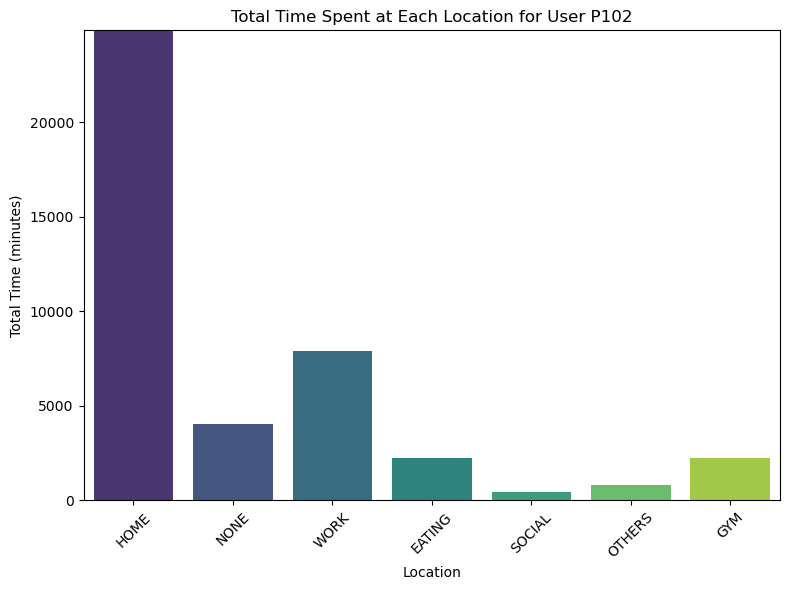

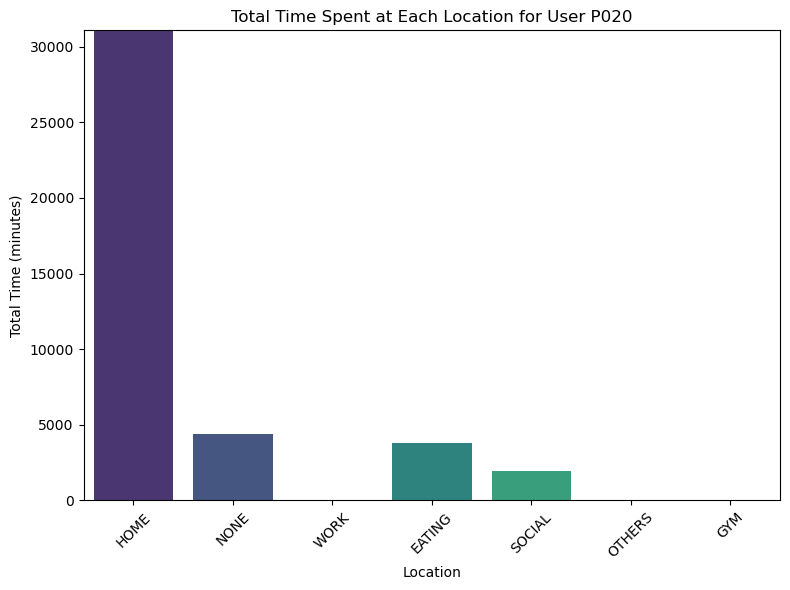

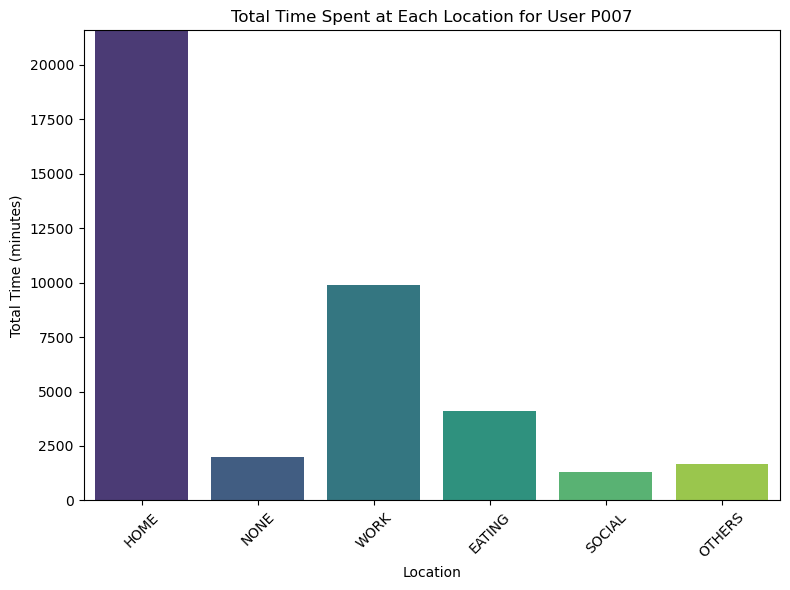

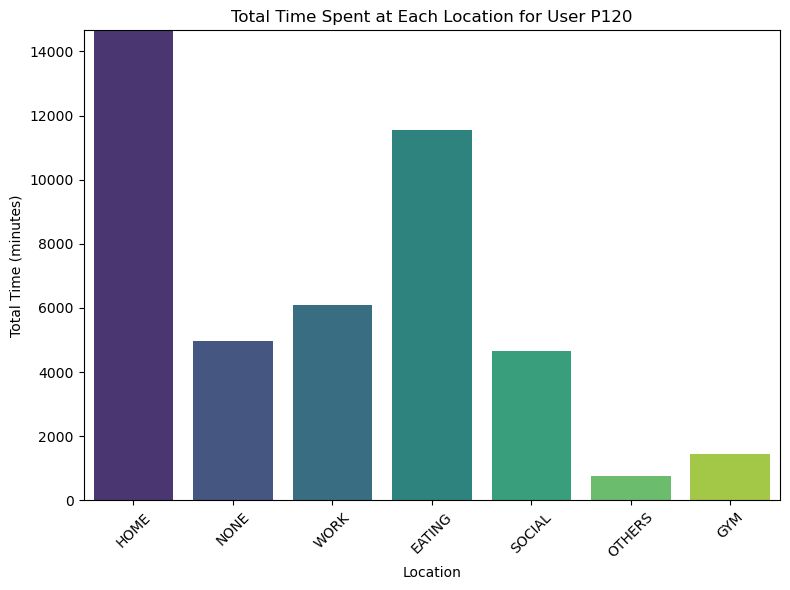

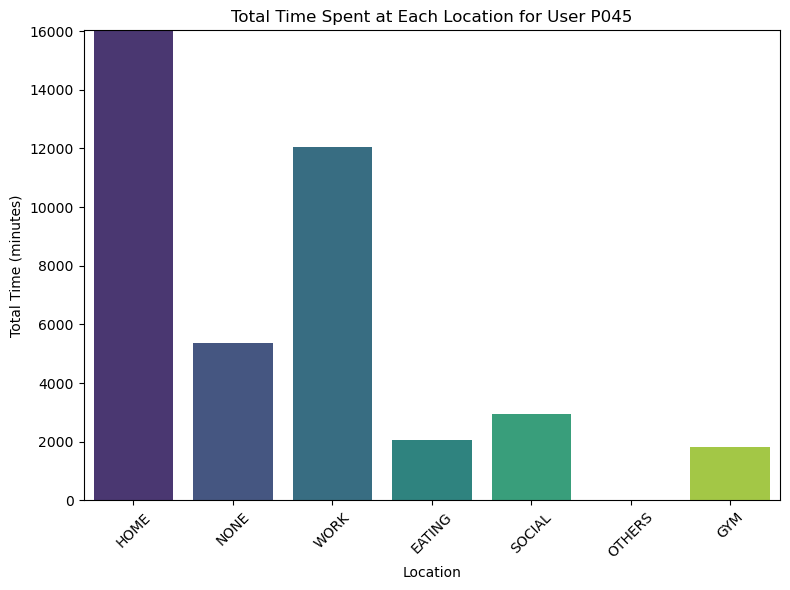

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# Iterate over each selected user to create individual bar charts
for pcode in selected_users:
    user_data = total_time_per_location.loc[pcode]
    user_data = user_data[user_data > 0]  # Filter out locations with zero time
    
    plt.figure(figsize=(8, 6))
    sns.barplot(x=user_data.index.str.replace('LOC_TIME_', ''), y=user_data.values, palette='viridis')
    plt.title(f'Total Time Spent at Each Location for User {pcode}')
    plt.xlabel('Location')
    plt.ylabel('Total Time (minutes)')
    plt.xticks(rotation=45)
    plt.ylim(0, user_data.max() + 10)  # Adjust y-axis for better visualization
    plt.tight_layout()
    plt.show()

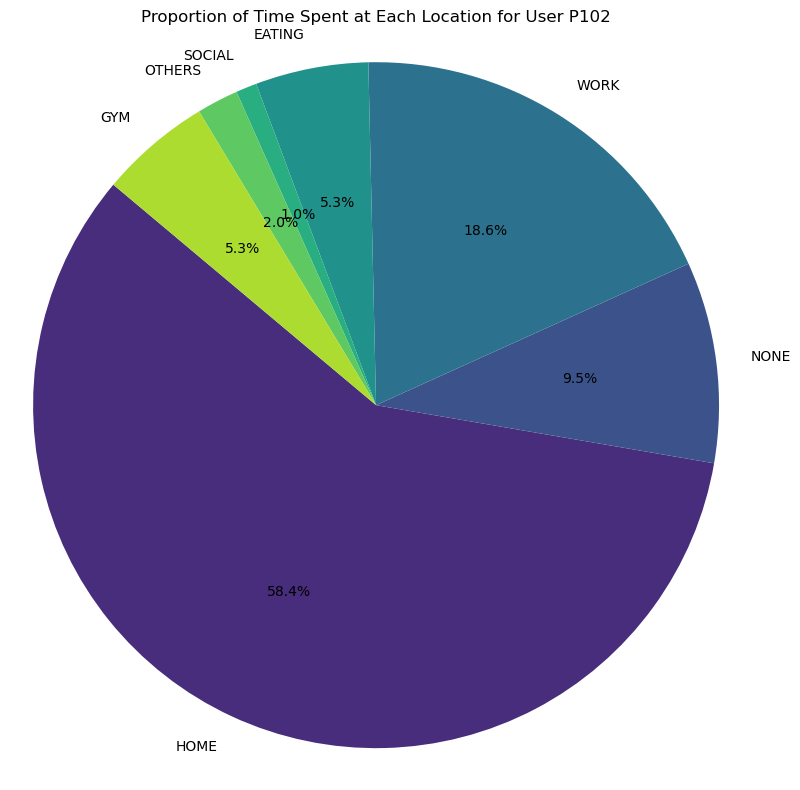

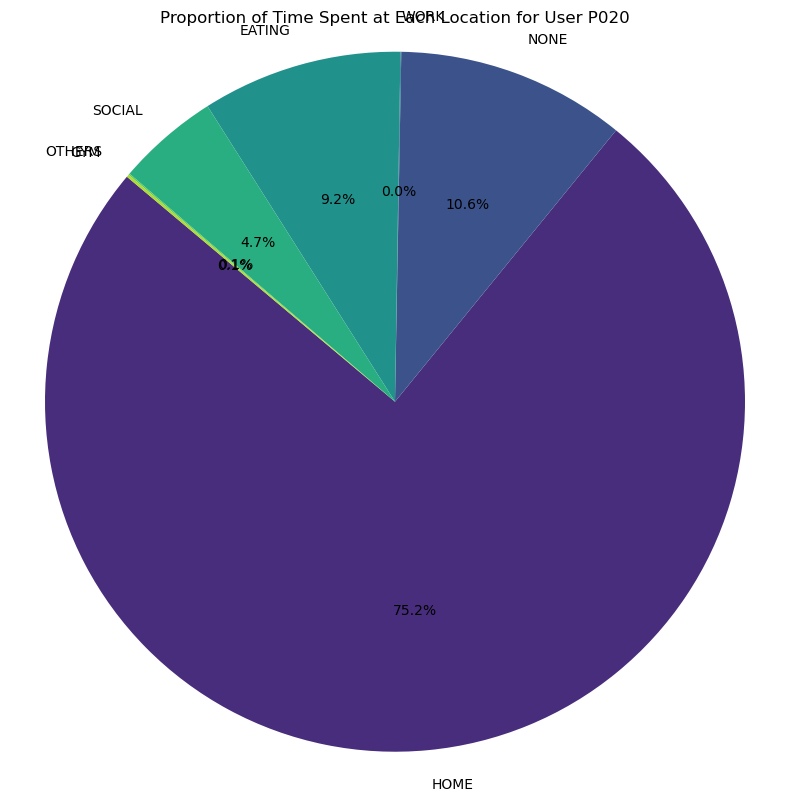

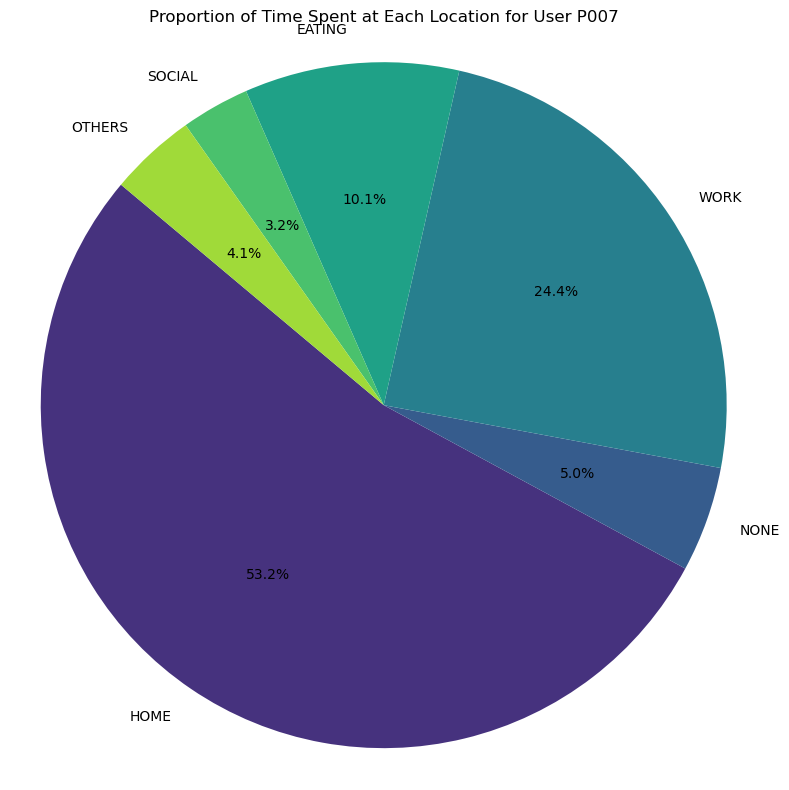

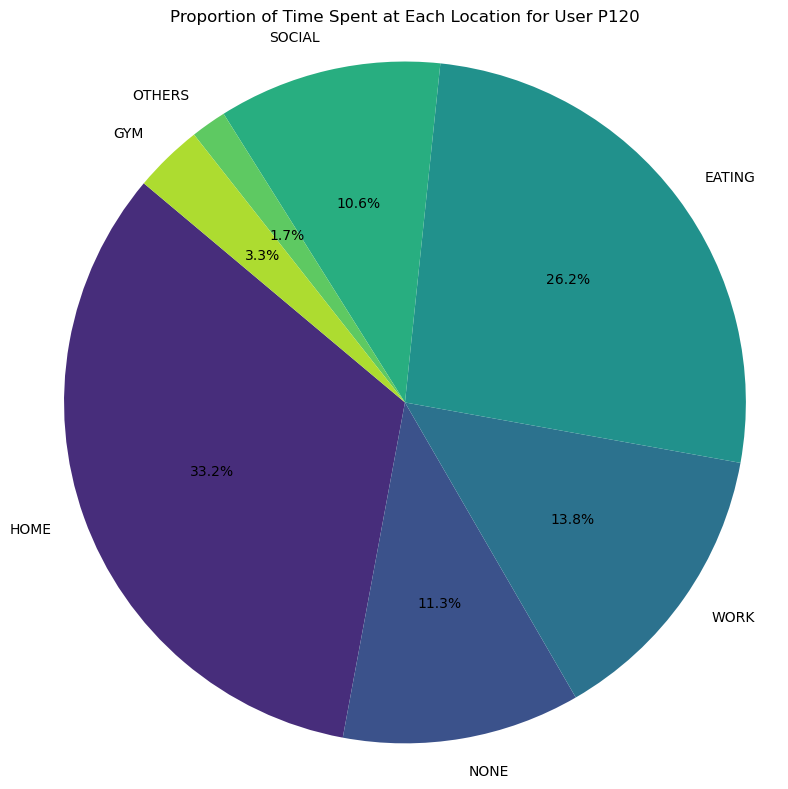

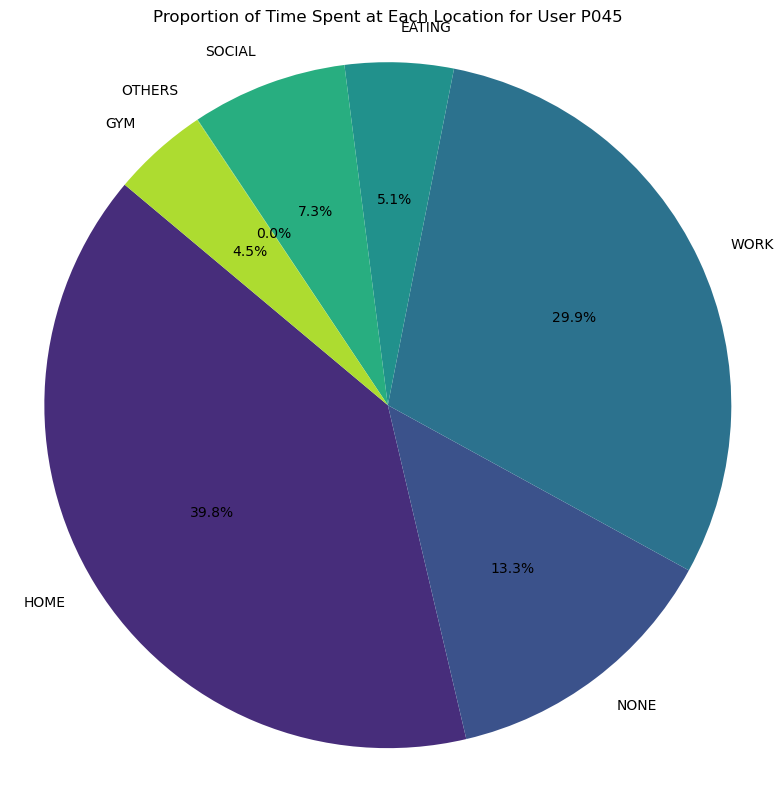

In [28]:
# Iterate over each selected user to create individual pie charts
for pcode in selected_users:
    user_proportion = proportion_time.loc[pcode]
    user_proportion = user_proportion[user_proportion > 0]  # Exclude zero proportions
    
    # If there are no non-zero proportions, skip plotting
    if user_proportion.empty:
        print(f"No time spent at any location for user {pcode}. Skipping pie chart.")
        continue
    
    plt.figure(figsize=(8, 8))
    plt.pie(user_proportion.values, labels=user_proportion.index.str.replace('PROP_TIME_', ''), autopct='%1.1f%%', startangle=140, colors=sns.color_palette('viridis', len(user_proportion)))
    plt.title(f'Proportion of Time Spent at Each Location for User {pcode}')
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.tight_layout()
    plt.show()

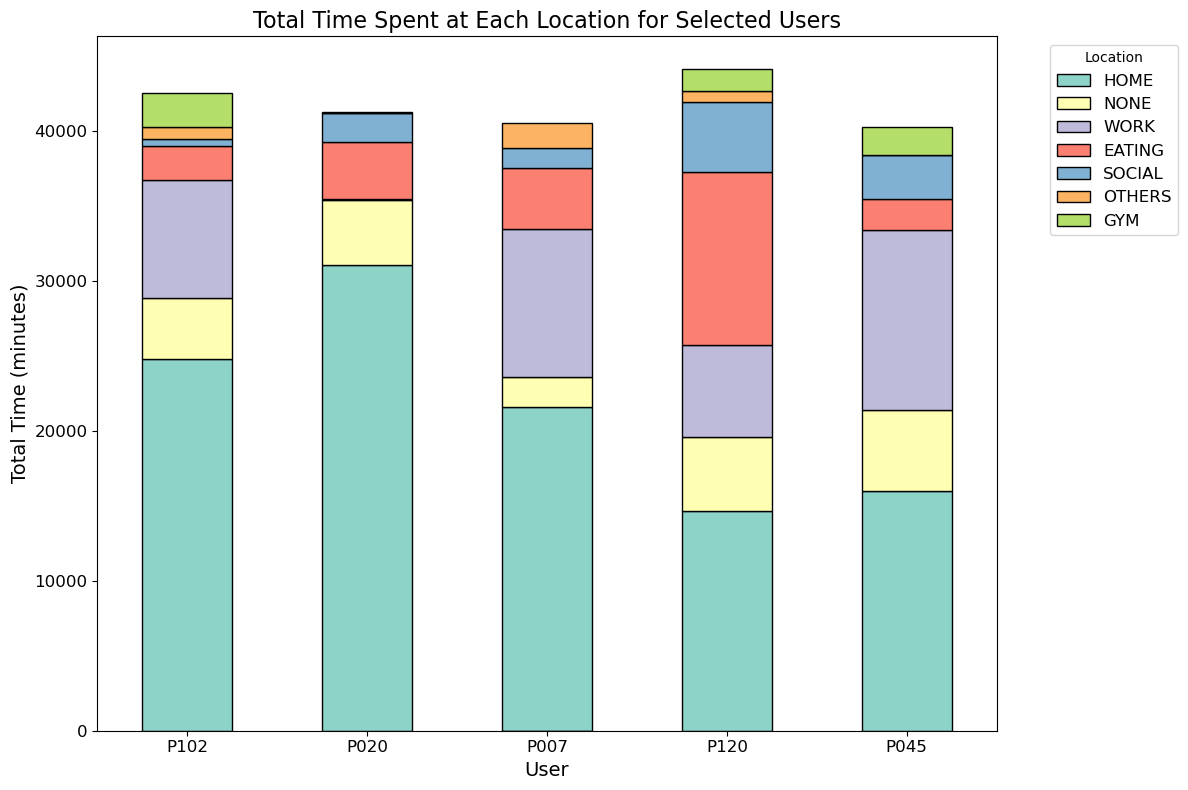

In [29]:
# # Alternatively, use the 'Set2' palette for distinct colors
# color_palette = sns.color_palette('Set2', n_colors=len(plot_data.columns))

# # Define a more contrasting color palette using 'tab20'
# color_palette = sns.color_palette('tab20', n_colors=len(plot_data.columns))

# # Define a custom list of contrasting colors
# color_palette = [
#     '#e41a1c',  # Red
#     '#377eb8',  # Blue
#     '#4daf4a',  # Green
#     '#984ea3',  # Purple
#     '#ff7f00',  # Orange
#     '#ffff33',  # Yellow
#     '#a65628',  # Brown
#     '#f781bf',  # Pink
#     '#999999',  # Grey
#     '#66c2a5'   # Teal
# ][:len(plot_data.columns)]  

import matplotlib.pyplot as plt
import seaborn as sns

# Select the relevant data for the selected users
plot_data = total_time_per_location.loc[selected_users]

# Rename columns by removing 'LOC_TIME_' prefix for clarity
plot_data = plot_data.rename(columns=lambda x: x.replace('LOC_TIME_', ''))

# Replace any remaining NaN values with 0 (if not already handled)
plot_data = plot_data.fillna(0)

# # Define a custom list of contrasting colors
color_palette = sns.color_palette('Set3', n_colors=len(plot_data.columns))
# Alternatively, you can choose another palette like 'Set2' or define custom colors as shown above

# Create a stacked bar chart
plot_data.plot(
    kind='bar',
    stacked=True,
    figsize=(12, 8),
    color=color_palette,
    edgecolor='black'
)

# Customize the plot
plt.title('Total Time Spent at Each Location for Selected Users', fontsize=16)
plt.xlabel('User', fontsize=14)
plt.ylabel('Total Time (minutes)', fontsize=14)
plt.xticks(rotation=0, fontsize=12)
plt.yticks(fontsize=12)

# Position the legend outside the plot
plt.legend(title='Location', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)

# Adjust layout to make room for the legend
plt.tight_layout()

# Display the plot
plt.show()

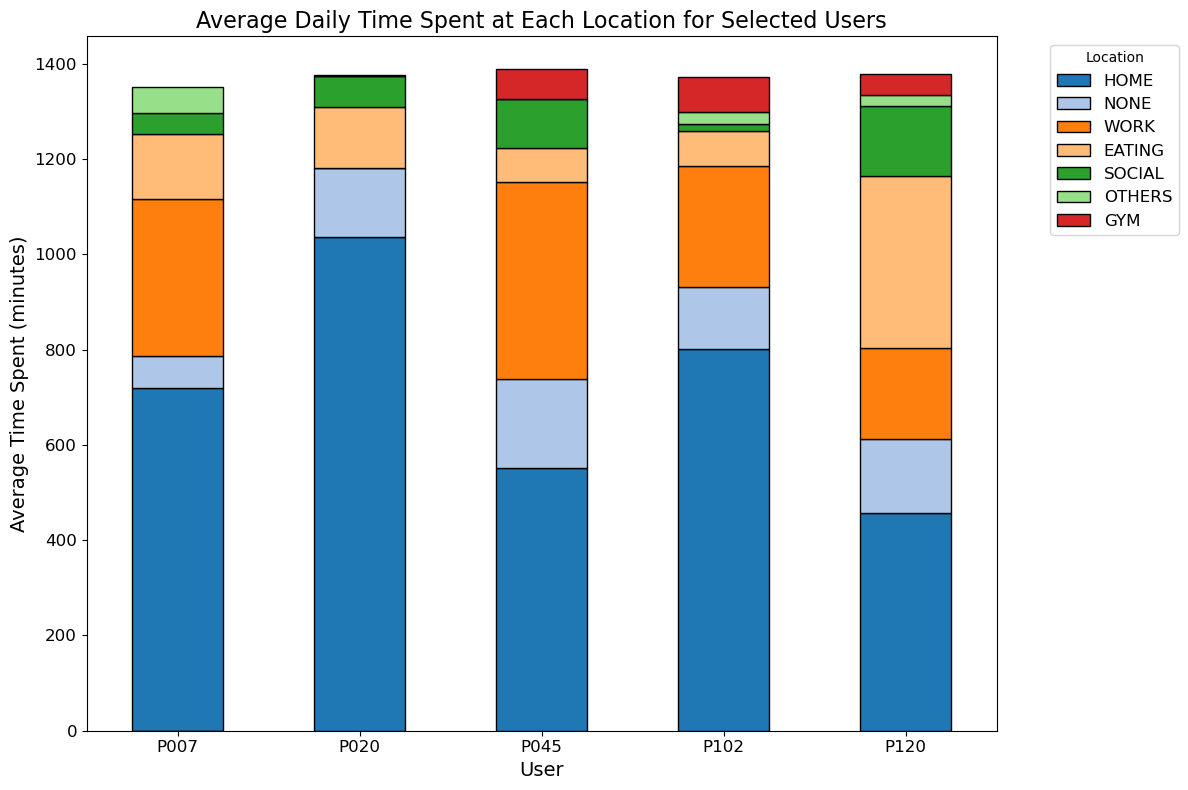

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'filtered_reset_df' is already defined and contains the cleaned data for selected users
# selected_users = ['P102', 'P020', 'P007', 'P120', 'P045']

# 1. Extract the date from 'window_end_time'
filtered_reset_df['date'] = filtered_reset_df['window_end_time'].dt.date

# 2. Aggregate time spent at each location per user per day
daily_time = filtered_reset_df.groupby(['pcode', 'date'])[loc_time_columns].sum().reset_index()

# 3. Calculate the mean daily time spent at each location per user
mean_daily_time = daily_time.groupby('pcode')[loc_time_columns].mean()

# 4. Rename columns by removing 'LOC_TIME_' prefix for clarity
mean_daily_time = mean_daily_time.rename(columns=lambda x: x.replace('LOC_TIME_', ''))

# 5. Define a contrasting color palette using 'tab20' for better distinction
color_palette = sns.color_palette('tab20', n_colors=len(mean_daily_time.columns))

# 6. Create a stacked bar chart for mean daily time spent at each location
mean_daily_time.plot(
    kind='bar',
    stacked=True,
    figsize=(12, 8),
    color=color_palette,
    edgecolor='black'
)

# 7. Customize the plot
plt.title('Average Daily Time Spent at Each Location for Selected Users', fontsize=16)
plt.xlabel('User', fontsize=14)
plt.ylabel('Average Time Spent (minutes)', fontsize=14)
plt.xticks(rotation=0, fontsize=12)
plt.yticks(fontsize=12)

# Position the legend outside the plot
plt.legend(title='Location', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)

# Adjust layout to make room for the legend
plt.tight_layout()

# 8. Display the plot
plt.show()


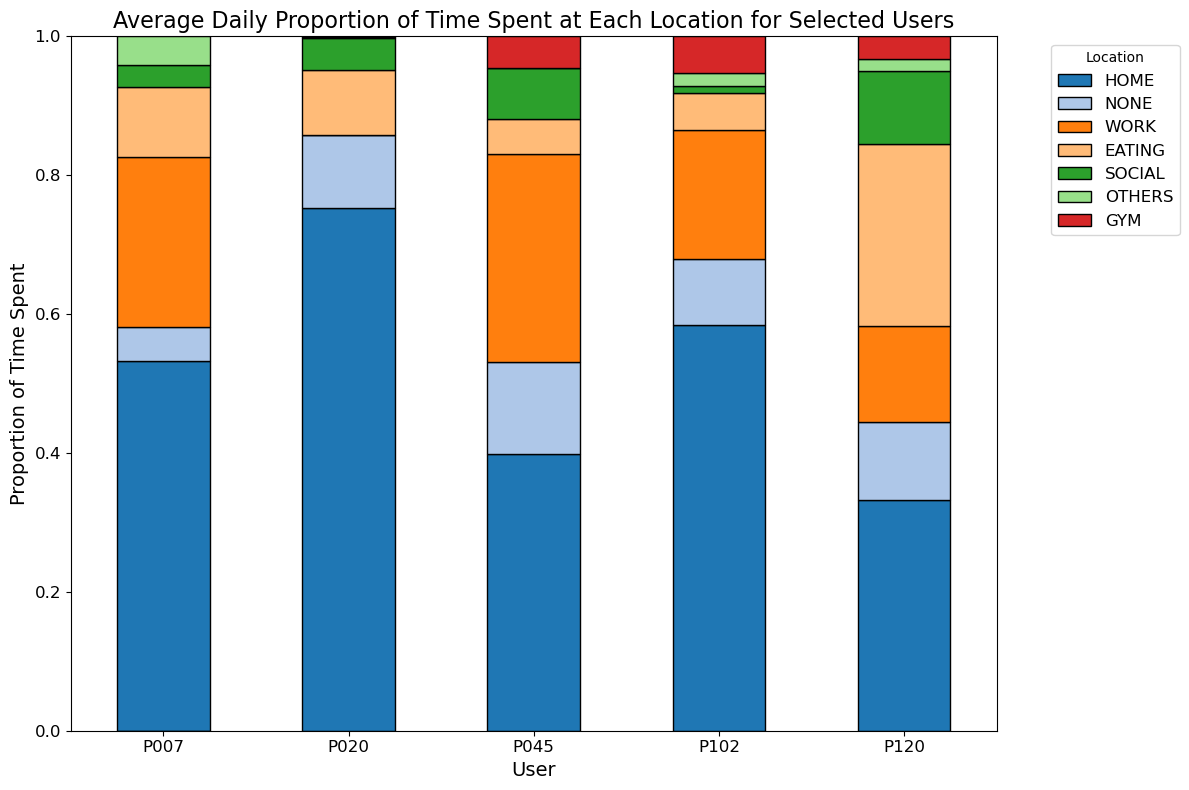

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'mean_daily_time' is already defined and contains the mean daily time per location per user
# selected_users = ['P102', 'P020', 'P007', 'P120', 'P045']

# 1. Normalize the data so that each user's total time sums to 1 (or 100%)
normalized_mean_daily_time = mean_daily_time.div(mean_daily_time.sum(axis=1), axis=0)

# 2. Replace any NaN values resulting from division by zero with 0
normalized_mean_daily_time = normalized_mean_daily_time.fillna(0)

# 3. Rename columns by removing 'LOC_TIME_' prefix for clarity
normalized_mean_daily_time = normalized_mean_daily_time.rename(columns=lambda x: x.replace('LOC_TIME_', ''))

# 4. Define a contrasting and colorblind-friendly color palette
# Using 'tab20' which has 20 distinct colors
color_palette = sns.color_palette('tab20', n_colors=len(normalized_mean_daily_time.columns))

# Alternatively, define a custom color palette for better distinction
# color_palette = [
#     '#e41a1c',  # Red
#     '#377eb8',  # Blue
#     '#4daf4a',  # Green
#     '#984ea3',  # Purple
#     '#ff7f00',  # Orange
#     '#ffff33',  # Yellow
#     '#a65628',  # Brown
#     '#f781bf',  # Pink
#     '#999999',  # Grey
#     '#66c2a5'   # Teal
# ][:len(normalized_mean_daily_time.columns)]  # Ensure the list matches the number of locations

# 5. Create a stacked bar chart with normalized data
ax = normalized_mean_daily_time.plot(
    kind='bar',
    stacked=True,
    figsize=(12, 8),
    color=color_palette,
    edgecolor='black'
)

# 6. Customize the plot
plt.title('Average Daily Proportion of Time Spent at Each Location for Selected Users', fontsize=16)
plt.xlabel('User', fontsize=14)
plt.ylabel('Proportion of Time Spent', fontsize=14)
plt.xticks(rotation=0, fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0, 1)  # Set y-axis from 0 to 1 for proportions

# 8. Position the legend outside the plot
plt.legend(title='Location', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)

# 9. Adjust layout to make room for the legend
plt.tight_layout()

# 10. Display the plot
plt.show()


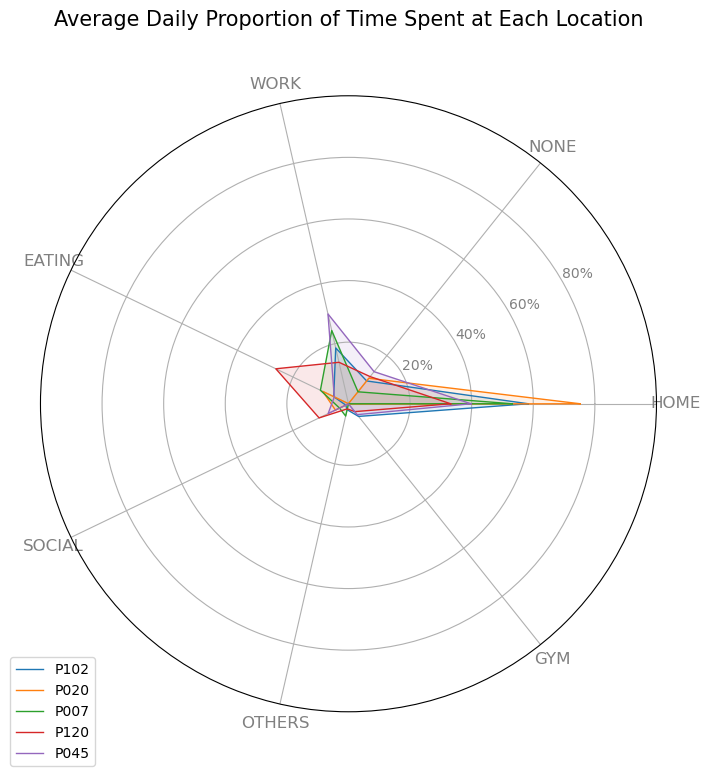

In [32]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Assuming 'mean_daily_time' includes 'Traveling_Time'
# Normalize the data if not already normalized
normalized_mean_daily_time = mean_daily_time.div(mean_daily_time.sum(axis=1), axis=0).fillna(0)

# Select the data for radar charts
data = normalized_mean_daily_time.loc[selected_users]

# Number of variables
categories = list(data.columns)
N = len(categories)

# What will be the angle of each axis in the plot? (we divide the plot / number of variables)
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]  # Complete the loop

# Initialize the radar plot
plt.figure(figsize=(8, 8))
ax = plt.subplot(111, polar=True)

# Draw one axe per variable + add labels
plt.xticks(angles[:-1], categories, color='grey', size=12)

# Draw ylabels
ax.set_rlabel_position(30)
plt.yticks([0.2,0.4,0.6,0.8], ["20%","40%","60%","80%"], color="grey", size=10)
plt.ylim(0,1)

# Plot each user
for user in selected_users:
    values = data.loc[user].tolist()
    values += values[:1]  # Complete the loop
    ax.plot(angles, values, linewidth=1, linestyle='solid', label=user)
    ax.fill(angles, values, alpha=0.1)

# Add a legend
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

plt.title('Average Daily Proportion of Time Spent at Each Location', size=15, y=1.1)
plt.show()


In [33]:
# Define the label that represents traveling. Adjust this if your traveling label is different.
travel_label = 'none'

# Check if the traveling label exists in the LOC_TIME_* columns
travel_time_column = f'LOC_TIME_{travel_label.upper()}'

if travel_time_column in filtered_reset_df.columns:
    # Assign Traveling_Time based on the travel_time_column
    filtered_reset_df['Traveling_Time'] = filtered_reset_df[travel_time_column]
else:
    # If the travel_time_column does not exist, set Traveling_Time to 0
    filtered_reset_df['Traveling_Time'] = 0

# Optionally, you can drop the travel_time_column if it's redundant
# filtered_reset_df.drop(columns=[travel_time_column], inplace=True)


In [34]:
# Display the first few rows to verify Traveling_Time
print("\nDataFrame with Calculated Traveling Time:\n", filtered_reset_df[['pcode', 'window_end_time', 'Traveling_Time']].head())

# Additionally, check if 'Traveling_Time' aligns with 'LOC_TIME_NONE'
if travel_time_column in filtered_reset_df.columns:
    print("\nSample of LOC_TIME_NONE and Traveling_Time:")
    print(filtered_reset_df[[travel_time_column, 'Traveling_Time']].head())



DataFrame with Calculated Traveling Time:
   pcode                  window_end_time  Traveling_Time
0  P102 2021-12-02 22:40:20.768000+09:00             0.0
1  P102 2021-12-02 23:17:35.627000+09:00             0.0
2  P102 2021-12-02 23:21:01.476000+09:00             0.0
3  P102 2021-12-02 23:23:52.193000+09:00             0.0
4  P102 2021-12-02 23:37:57.030000+09:00             0.0

Sample of LOC_TIME_NONE and Traveling_Time:
   LOC_TIME_NONE  Traveling_Time
0            0.0             0.0
1            0.0             0.0
2            0.0             0.0
3            0.0             0.0
4            0.0             0.0


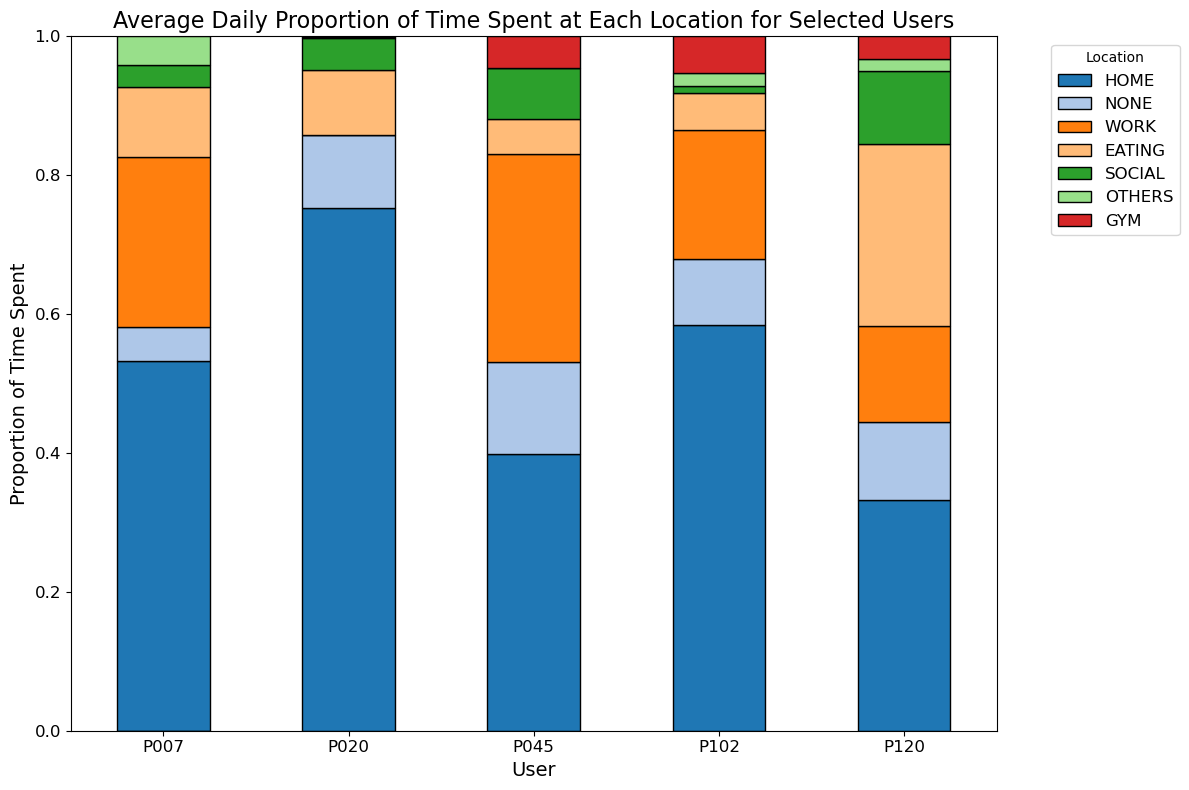

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Normalize the data so that each user's total time sums to 1 (or 100%)
normalized_mean_daily_time = mean_daily_time.div(mean_daily_time.sum(axis=1), axis=0)

# 2. Replace any NaN values resulting from division by zero with 0
normalized_mean_daily_time = normalized_mean_daily_time.fillna(0)

# 3. Rename columns by removing 'LOC_TIME_' prefix for clarity (if not already done)
# Already handled in previous step

# 4. Define a contrasting and colorblind-friendly color palette
# Using 'tab20' which has 20 distinct colors, more than enough for your locations
color_palette = sns.color_palette('tab20', n_colors=len(normalized_mean_daily_time.columns))

# 5. Create a stacked bar chart with normalized data
ax = normalized_mean_daily_time.plot(
    kind='bar',
    stacked=True,
    figsize=(12, 8),
    color=color_palette,
    edgecolor='black'
)

# 6. Customize the plot
plt.title('Average Daily Proportion of Time Spent at Each Location for Selected Users', fontsize=16)
plt.xlabel('User', fontsize=14)
plt.ylabel('Proportion of Time Spent', fontsize=14)
plt.xticks(rotation=0, fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0, 1)  # Set y-axis from 0 to 1 for proportions

# 8. Position the legend outside the plot
plt.legend(title='Location', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)

# 9. Adjust layout to make room for the legend
plt.tight_layout()

# 10. Display the plot
plt.show()

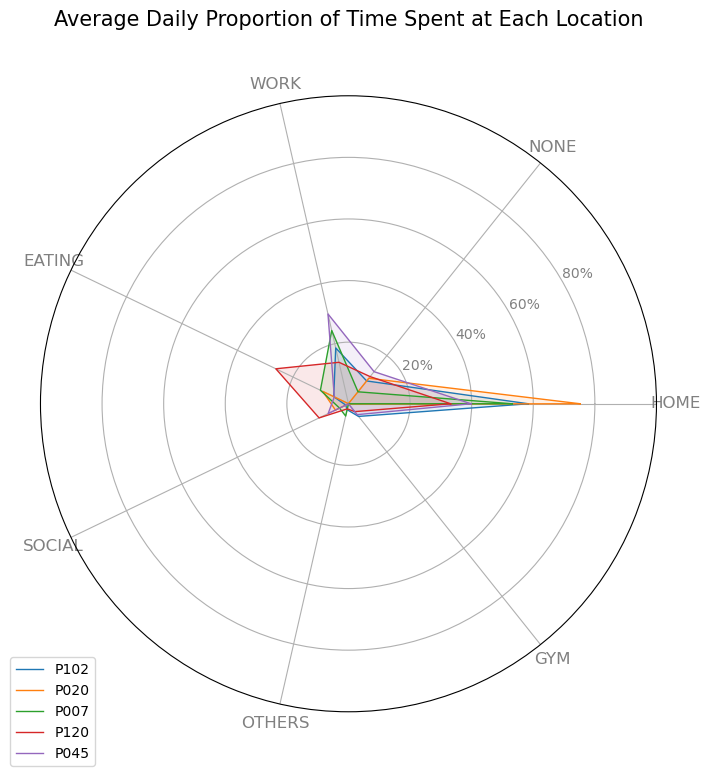

In [36]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Assuming 'mean_daily_time' includes 'Traveling_Time'
# Normalize the data if not already normalized
normalized_mean_daily_time = mean_daily_time.div(mean_daily_time.sum(axis=1), axis=0).fillna(0)

# Select the data for radar charts
data = normalized_mean_daily_time.loc[selected_users]

# Number of variables
categories = list(data.columns)
N = len(categories)

# What will be the angle of each axis in the plot? (we divide the plot / number of variables)
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]  # Complete the loop

# Initialize the radar plot
plt.figure(figsize=(8, 8))
ax = plt.subplot(111, polar=True)

# Draw one axe per variable + add labels
plt.xticks(angles[:-1], categories, color='grey', size=12)

# Draw ylabels
ax.set_rlabel_position(30)
plt.yticks([0.2,0.4,0.6,0.8], ["20%","40%","60%","80%"], color="grey", size=10)
plt.ylim(0,1)

# Plot each user
for user in selected_users:
    values = data.loc[user].tolist()
    values += values[:1]  # Complete the loop
    ax.plot(angles, values, linewidth=1, linestyle='solid', label=user)
    ax.fill(angles, values, alpha=0.1)

# Add a legend
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

plt.title('Average Daily Proportion of Time Spent at Each Location', size=15, y=1.1)
plt.show()

2024-11-13 04:55:08,091 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-11-13 04:55:08,093 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


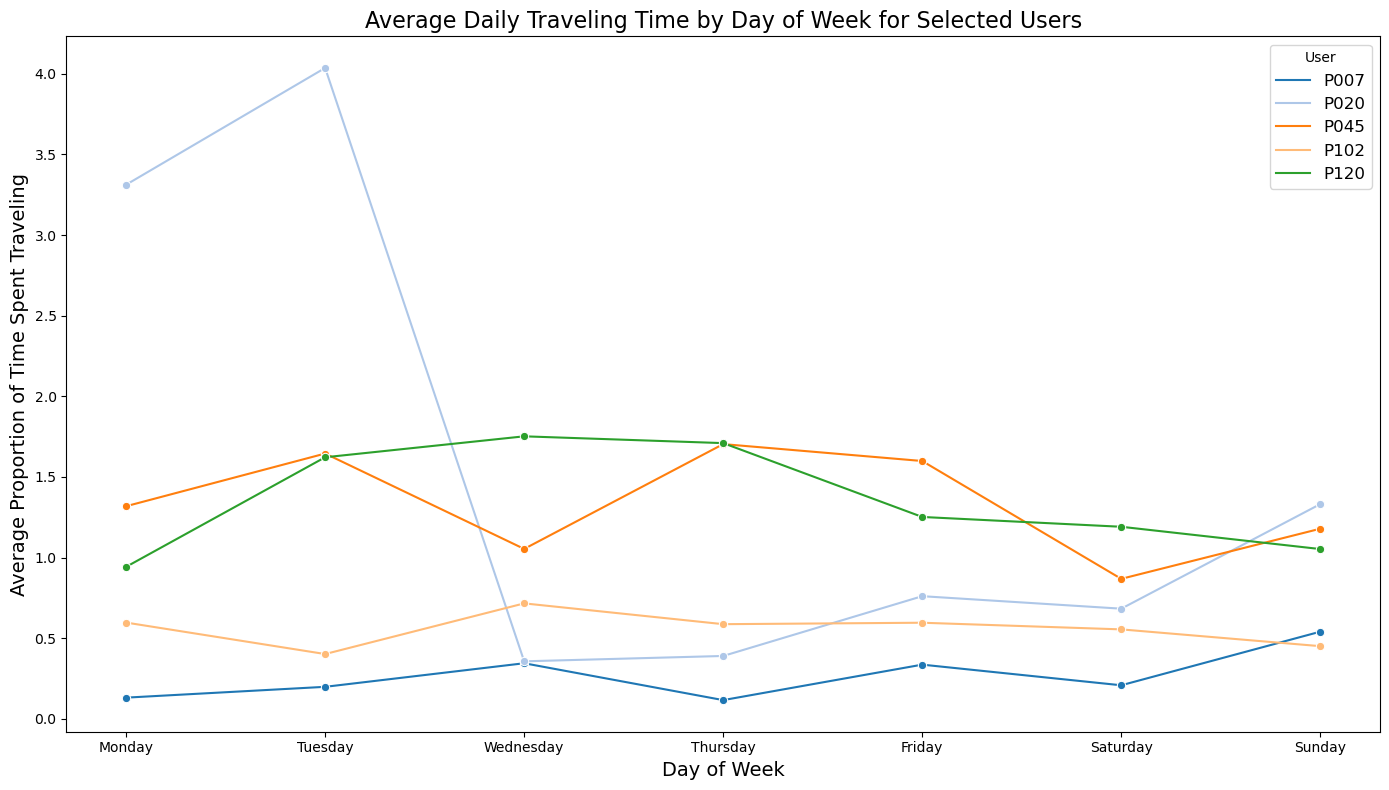

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'filtered_reset_df' includes 'date' and normalized 'Traveling_Time'

# Add 'day_of_week' for additional insights
filtered_reset_df['day_of_week'] = filtered_reset_df['window_end_time'].dt.day_name()

# Aggregate mean time per location per user per day of week
daily_time = filtered_reset_df.groupby(['pcode', 'day_of_week'])[loc_time_columns + ['Traveling_Time']].mean().reset_index()

# Order days of the week
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
daily_time['day_of_week'] = pd.Categorical(daily_time['day_of_week'], categories=days_order, ordered=True)

plt.figure(figsize=(14, 8))
sns.lineplot(
    data=daily_time,
    x='day_of_week',
    y='Traveling_Time',
    hue='pcode',
    marker='o',
    palette='tab20'
)
plt.title('Average Daily Traveling Time by Day of Week for Selected Users', fontsize=16)
plt.xlabel('Day of Week', fontsize=14)
plt.ylabel('Average Proportion of Time Spent Traveling', fontsize=14)
plt.legend(title='User', fontsize=12)
plt.tight_layout()
plt.show()


In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.dates as mdates
import random

In [66]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random

# Assuming 'filtered_reset_df' is your DataFrame with the following columns:
# 'pcode', 'window_end_time', 'LOC_TIME_HOME', 'LOC_TIME_WORK', ..., 'Traveling_Time'
# and that 'window_end_time' is in datetime format

# Define the window size in minutes (adjust if different)
window_size = 60  # e.g., 60 minutes

# Select a random date present in the data
available_dates = filtered_reset_df['window_end_time'].dt.date.unique()
selected_date = random.choice(available_dates)
print(f"Selected Date for Visualization: {selected_date}")

# Filter data for the selected date and selected users
selected_users = ['P102', 'P020', 'P007', 'P120', 'P045']
day_data = filtered_reset_df[
    (filtered_reset_df['pcode'].isin(selected_users)) &
    (filtered_reset_df['window_end_time'].dt.date == selected_date)
].copy()

# Check if all users have data for the selected date
users_with_data = day_data['pcode'].unique()
missing_users = set(selected_users) - set(users_with_data)
if missing_users:
    print(f"Warning: The following users do not have data for {selected_date}: {missing_users}")

# Assign primary activity per window based on maximum time spent
loc_time_columns = [col for col in day_data.columns if col.startswith('LOC_TIME_')]
day_data['Primary_Activity'] = day_data[loc_time_columns + ['Traveling_Time']].idxmax(axis=1)
day_data['Primary_Activity'] = day_data['Primary_Activity'].str.replace('LOC_TIME_', '').str.replace('_', ' ')

# Calculate start and end times for each activity
day_data['window_start_time'] = day_data['window_end_time'] - pd.to_timedelta(window_size, unit='m')
day_data = day_data.sort_values(['pcode', 'window_start_time'])

Selected Date for Visualization: 2021-12-06


In [67]:
# Define a contrasting color palette
activity_colors = {
    'HOME': '#1f77b4',           # Blue
    'WORK': '#ff7f0e',           # Orange
    'EATING': '#2ca02c',         # Green
    'SOCIAL': '#d62728',         # Red
    'GYM': '#9467bd',            # Purple
    'OTHERS': '#8c564b',         # Brown
}

# Ensure all activities have a color
unique_activities = day_data['Primary_Activity'].unique()
for activity in unique_activities:
    if activity not in activity_colors:
        activity_colors[activity] = '#7f7f7f'  # Grey as default


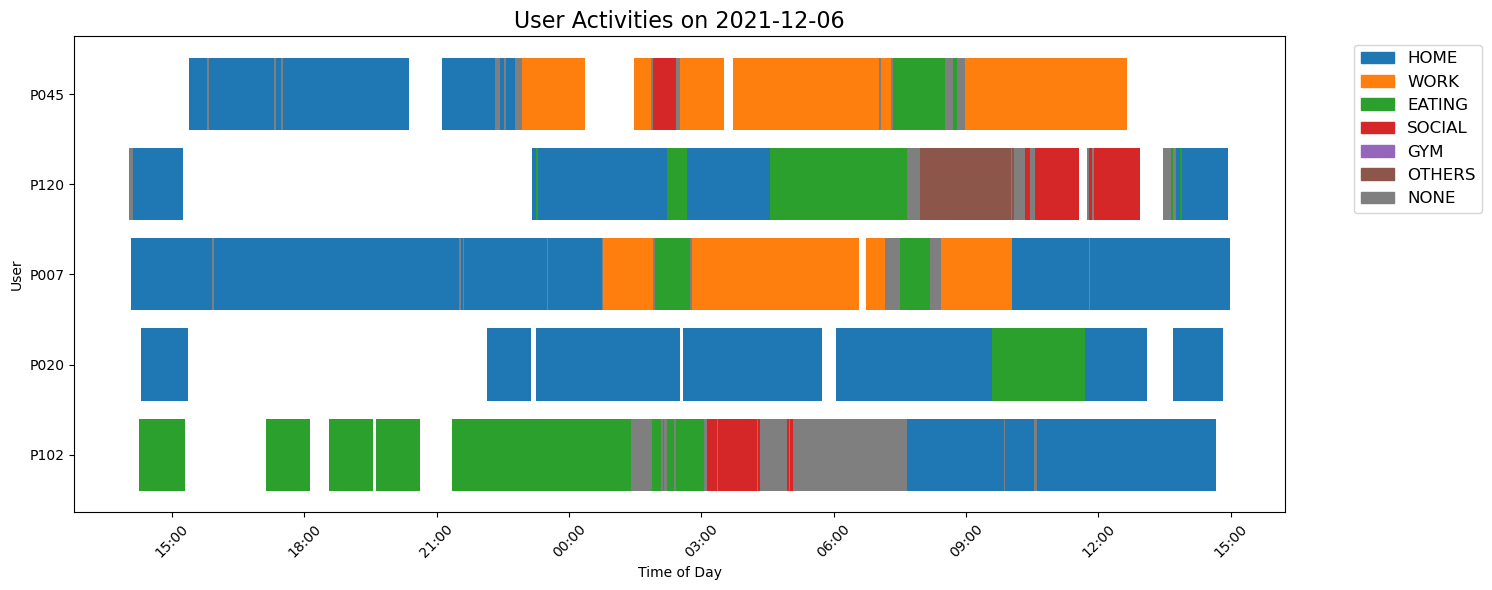

In [68]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.dates as mdates

# Initialize the plot
fig, ax = plt.subplots(figsize=(15, 6))

# Assign a y-position for each user
user_positions = {user: idx for idx, user in enumerate(selected_users)}
yticks = []
yticklabels = []
for user, pos in user_positions.items():
    yticks.append(pos)
    yticklabels.append(user)

# Set y-axis
ax.set_yticks(yticks)
ax.set_yticklabels(yticklabels)
ax.set_xlabel('Time of Day')
ax.set_ylabel('User')
ax.set_title(f'User Activities on {selected_date}', fontsize=16)

# Format x-axis as time
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.xticks(rotation=45)

# Plot each activity as a horizontal bar
for _, row in day_data.iterrows():
    user = row['pcode']
    pos = user_positions[user]
    start_time = row['window_start_time']
    duration = (row['window_end_time'] - row['window_start_time']).seconds / 60  # duration in minutes
    activity = row['Primary_Activity']
    color = activity_colors.get(activity, '#7f7f7f')  # Default to grey if not found
    ax.broken_barh(
        [(start_time, pd.Timedelta(minutes=duration))],
        (pos - 0.4, 0.8),
        facecolors=color
    )

# Create custom legend
legend_patches = [patches.Patch(color=color, label=activity) for activity, color in activity_colors.items()]
ax.legend(handles=legend_patches, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)

plt.tight_layout()
plt.show()